In [23]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from src.model import CNNModel
from src.train import *
from src.utils import *
from src.prepare_data import *

In [3]:
# from prepare_data import generate_data, get_train_test_data


data = generate_data(noise_level=0.1, img_size=100, num_samples=30000)

../data/noise_0.1_size_100_samples_30000.pkl
Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.1_size_100_samples_30000.pkl


In [4]:
train_loader, test_loader = get_train_test_data(noise_level=0.1, img_size=100, num_samples=30000)

../data/noise_0.1_size_100_samples_30000.pkl
Using parameters: noise_level=0.1, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Data saved to ../data/noise_0.1_size_100_samples_30000.pkl


/afs/cs.wisc.edu/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/src/prepare_data.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)


DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7f64637215d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f6463721180>)
Length of train data loader: 750 batches of 32
Length of test data loader: 188 batches of 32


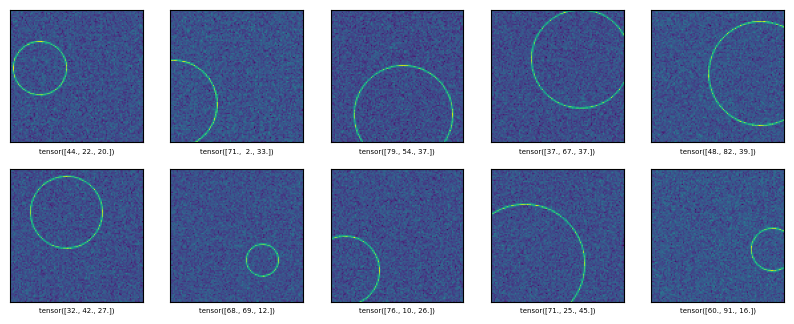

In [5]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_features_batch, train_labels_batch = next(iter(train_loader))
    plt.imshow(train_features_batch[i].squeeze())
    plt.xlabel(train_labels_batch[i], fontsize = 5)

In [6]:
from torch import nn
class m0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [7]:
import torch.nn.functional as F
from torch import nn


class m1(nn.Module):
    def __init__(self, input_shape=1, hidden_units=64, output_shape=3, img_size=100):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), # [1, 64]
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1), #[64, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),#[128, 256]
            nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),#[256, 256]
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out_layer = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=hidden_units*4*25*25, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # # print(x.shape)
        x = self.conv_block2(x)
        # # print(x.shape)
        x = self.out_layer(x)
        # print(x.shape)
        return x

In [8]:

# cuda.empty_cache()


model = m1().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001)

In [9]:


torch.manual_seed(42)
start_time= timer()
print("Hi")
epochs = 100
train_losses = []
test_losses = []
test_accs = []
epochs_ = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_loss, train_acc = train_step(model = model,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    test_loss, test_acc = test_step(model = model,
               data_loader=test_loader,
               loss_fn=loss_fn,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    epochs_.append(epoch)
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    test_accs.append(test_acc)





    # Calculate training time
    end_time = timer()
    total_train_time_model = print_train_time(start=start_time,
                                                end=end_time,
                                                device=str(next(model.parameters()).device))

Hi


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
--------
cuda
Train Loss:  233.24771 | Train Accuracy: 0.36


  1%|          | 1/100 [01:30<2:30:04, 90.96s/it]

Test Loss:  62.22779 | Test Accuracy: 0.62
Train time on cuda:0: 90.965 seconds
Epoch: 1
--------
cuda
Train Loss:  42.39236 | Train Accuracy: 0.76


  2%|▏         | 2/100 [01:57<1:26:31, 52.97s/it]

Test Loss:  40.22072 | Test Accuracy: 0.77
Train time on cuda:0: 117.348 seconds
Epoch: 2
--------
cuda
Train Loss:  33.28799 | Train Accuracy: 0.81


  3%|▎         | 3/100 [02:23<1:06:06, 40.89s/it]

Test Loss:  31.04808 | Test Accuracy: 0.82
Train time on cuda:0: 143.862 seconds
Epoch: 3
--------
cuda
Train Loss:  28.80680 | Train Accuracy: 0.84


  4%|▍         | 4/100 [02:50<56:25, 35.27s/it]  

Test Loss:  26.55863 | Test Accuracy: 0.86
Train time on cuda:0: 170.513 seconds
Epoch: 4
--------
cuda
Train Loss:  25.62326 | Train Accuracy: 0.86


  5%|▌         | 5/100 [03:17<50:53, 32.14s/it]

Test Loss:  25.87440 | Test Accuracy: 0.83
Train time on cuda:0: 197.112 seconds
Epoch: 5
--------
cuda
Train Loss:  23.06864 | Train Accuracy: 0.87


  6%|▌         | 6/100 [03:43<47:28, 30.30s/it]

Test Loss:  23.65639 | Test Accuracy: 0.86
Train time on cuda:0: 223.833 seconds
Epoch: 6
--------
cuda
Train Loss:  21.12419 | Train Accuracy: 0.88


  7%|▋         | 7/100 [04:11<45:27, 29.33s/it]

Test Loss:  22.09302 | Test Accuracy: 0.86
Train time on cuda:0: 251.155 seconds
Epoch: 7
--------
cuda
Train Loss:  19.74031 | Train Accuracy: 0.88


  8%|▊         | 8/100 [04:37<43:39, 28.47s/it]

Test Loss:  19.97267 | Test Accuracy: 0.89
Train time on cuda:0: 277.793 seconds
Epoch: 8
--------
cuda
Train Loss:  18.22810 | Train Accuracy: 0.89


  9%|▉         | 9/100 [05:04<42:22, 27.94s/it]

Test Loss:  19.00620 | Test Accuracy: 0.87
Train time on cuda:0: 304.582 seconds
Epoch: 9
--------
cuda
Train Loss:  16.74343 | Train Accuracy: 0.89


 10%|█         | 10/100 [05:31<41:21, 27.57s/it]

Test Loss:  18.06399 | Test Accuracy: 0.90
Train time on cuda:0: 331.323 seconds
Epoch: 10
--------
cuda
Train Loss:  14.66672 | Train Accuracy: 0.91


 11%|█         | 11/100 [05:58<40:34, 27.35s/it]

Test Loss:  16.07103 | Test Accuracy: 0.91
Train time on cuda:0: 358.170 seconds
Epoch: 11
--------
cuda
Train Loss:  12.69730 | Train Accuracy: 0.92


 12%|█▏        | 12/100 [06:24<39:51, 27.18s/it]

Test Loss:  13.45401 | Test Accuracy: 0.90
Train time on cuda:0: 384.947 seconds
Epoch: 12
--------
cuda
Train Loss:  11.20998 | Train Accuracy: 0.93


 13%|█▎        | 13/100 [06:51<39:12, 27.04s/it]

Test Loss:  12.85601 | Test Accuracy: 0.93
Train time on cuda:0: 411.675 seconds
Epoch: 13
--------
cuda
Train Loss:  9.89984 | Train Accuracy: 0.93


 14%|█▍        | 14/100 [07:18<38:38, 26.96s/it]

Test Loss:  12.14284 | Test Accuracy: 0.91
Train time on cuda:0: 438.454 seconds
Epoch: 14
--------
cuda
Train Loss:  9.08037 | Train Accuracy: 0.94


 15%|█▌        | 15/100 [07:45<38:05, 26.89s/it]

Test Loss:  11.40173 | Test Accuracy: 0.94
Train time on cuda:0: 465.169 seconds
Epoch: 15
--------
cuda
Train Loss:  8.25121 | Train Accuracy: 0.94


 16%|█▌        | 16/100 [08:11<37:35, 26.85s/it]

Test Loss:  10.05029 | Test Accuracy: 0.92
Train time on cuda:0: 491.943 seconds
Epoch: 16
--------
cuda
Train Loss:  7.42403 | Train Accuracy: 0.95


 17%|█▋        | 17/100 [08:38<37:06, 26.82s/it]

Test Loss:  10.18324 | Test Accuracy: 0.94
Train time on cuda:0: 518.699 seconds
Epoch: 17
--------
cuda
Train Loss:  6.79982 | Train Accuracy: 0.95


 18%|█▊        | 18/100 [09:05<36:37, 26.80s/it]

Test Loss:  9.34513 | Test Accuracy: 0.93
Train time on cuda:0: 545.430 seconds
Epoch: 18
--------
cuda
Train Loss:  6.31846 | Train Accuracy: 0.95


 19%|█▉        | 19/100 [09:32<36:08, 26.78s/it]

Test Loss:  8.71317 | Test Accuracy: 0.95
Train time on cuda:0: 572.164 seconds
Epoch: 19
--------
cuda
Train Loss:  5.80245 | Train Accuracy: 0.96


 20%|██        | 20/100 [09:58<35:40, 26.76s/it]

Test Loss:  8.06443 | Test Accuracy: 0.94
Train time on cuda:0: 598.885 seconds
Epoch: 20
--------
cuda
Train Loss:  5.30412 | Train Accuracy: 0.96


 21%|██        | 21/100 [10:25<35:13, 26.76s/it]

Test Loss:  9.13246 | Test Accuracy: 0.91
Train time on cuda:0: 625.629 seconds
Epoch: 21
--------
cuda
Train Loss:  4.88397 | Train Accuracy: 0.96


 22%|██▏       | 22/100 [10:52<34:46, 26.75s/it]

Test Loss:  7.68239 | Test Accuracy: 0.95
Train time on cuda:0: 652.382 seconds
Epoch: 22
--------
cuda
Train Loss:  4.57262 | Train Accuracy: 0.97


 23%|██▎       | 23/100 [11:18<34:16, 26.71s/it]

Test Loss:  7.40358 | Test Accuracy: 0.94
Train time on cuda:0: 678.997 seconds
Epoch: 23
--------
cuda
Train Loss:  4.18938 | Train Accuracy: 0.97


 24%|██▍       | 24/100 [11:45<33:51, 26.72s/it]

Test Loss:  7.65594 | Test Accuracy: 0.93
Train time on cuda:0: 705.750 seconds
Epoch: 24
--------
cuda
Train Loss:  3.94126 | Train Accuracy: 0.97


 25%|██▌       | 25/100 [12:12<33:23, 26.72s/it]

Test Loss:  6.76394 | Test Accuracy: 0.94
Train time on cuda:0: 732.449 seconds
Epoch: 25
--------
cuda
Train Loss:  3.52056 | Train Accuracy: 0.98


 26%|██▌       | 26/100 [12:39<32:57, 26.73s/it]

Test Loss:  6.57631 | Test Accuracy: 0.95
Train time on cuda:0: 759.197 seconds
Epoch: 26
--------
cuda
Train Loss:  3.29045 | Train Accuracy: 0.98


 27%|██▋       | 27/100 [13:05<32:31, 26.73s/it]

Test Loss:  6.36619 | Test Accuracy: 0.95
Train time on cuda:0: 785.947 seconds
Epoch: 27
--------
cuda
Train Loss:  3.01430 | Train Accuracy: 0.98


 28%|██▊       | 28/100 [13:32<32:04, 26.73s/it]

Test Loss:  6.36132 | Test Accuracy: 0.96
Train time on cuda:0: 812.664 seconds
Epoch: 28
--------
cuda
Train Loss:  2.78758 | Train Accuracy: 0.98


 29%|██▉       | 29/100 [13:59<31:38, 26.74s/it]

Test Loss:  6.18464 | Test Accuracy: 0.95
Train time on cuda:0: 839.435 seconds
Epoch: 29
--------
cuda
Train Loss:  2.60047 | Train Accuracy: 0.99


 30%|███       | 30/100 [14:26<31:12, 26.75s/it]

Test Loss:  6.09380 | Test Accuracy: 0.96
Train time on cuda:0: 866.199 seconds
Epoch: 30
--------
cuda
Train Loss:  2.41662 | Train Accuracy: 0.99


 31%|███       | 31/100 [14:52<30:46, 26.76s/it]

Test Loss:  5.75519 | Test Accuracy: 0.95
Train time on cuda:0: 892.972 seconds
Epoch: 31
--------
cuda
Train Loss:  2.22522 | Train Accuracy: 0.99


 32%|███▏      | 32/100 [15:19<30:19, 26.76s/it]

Test Loss:  6.32572 | Test Accuracy: 0.97
Train time on cuda:0: 919.735 seconds
Epoch: 32
--------
cuda
Train Loss:  2.04656 | Train Accuracy: 0.99


 33%|███▎      | 33/100 [15:46<29:53, 26.77s/it]

Test Loss:  5.62094 | Test Accuracy: 0.95
Train time on cuda:0: 946.522 seconds
Epoch: 33
--------
cuda
Train Loss:  1.92633 | Train Accuracy: 0.99


 34%|███▍      | 34/100 [16:13<29:29, 26.80s/it]

Test Loss:  5.53300 | Test Accuracy: 0.96
Train time on cuda:0: 973.413 seconds
Epoch: 34
--------
cuda
Train Loss:  1.78136 | Train Accuracy: 0.99


 35%|███▌      | 35/100 [16:40<29:01, 26.79s/it]

Test Loss:  5.80275 | Test Accuracy: 0.95
Train time on cuda:0: 1000.181 seconds
Epoch: 35
--------
cuda
Train Loss:  1.61647 | Train Accuracy: 0.99


 36%|███▌      | 36/100 [17:06<28:33, 26.77s/it]

Test Loss:  5.53831 | Test Accuracy: 0.96
Train time on cuda:0: 1026.912 seconds
Epoch: 36
--------
cuda
Train Loss:  1.48216 | Train Accuracy: 0.99


 37%|███▋      | 37/100 [17:33<28:06, 26.77s/it]

Test Loss:  5.19778 | Test Accuracy: 0.96
Train time on cuda:0: 1053.674 seconds
Epoch: 37
--------
cuda
Train Loss:  1.43730 | Train Accuracy: 1.00


 38%|███▊      | 38/100 [18:00<27:38, 26.76s/it]

Test Loss:  5.68900 | Test Accuracy: 0.96
Train time on cuda:0: 1080.399 seconds
Epoch: 38
--------
cuda
Train Loss:  1.34627 | Train Accuracy: 1.00


 39%|███▉      | 39/100 [18:27<27:12, 26.75s/it]

Test Loss:  5.65915 | Test Accuracy: 0.94
Train time on cuda:0: 1107.148 seconds
Epoch: 39
--------
cuda
Train Loss:  1.21319 | Train Accuracy: 1.00


 40%|████      | 40/100 [18:53<26:46, 26.77s/it]

Test Loss:  4.97524 | Test Accuracy: 0.96
Train time on cuda:0: 1133.944 seconds
Epoch: 40
--------
cuda
Train Loss:  1.12550 | Train Accuracy: 1.00


 41%|████      | 41/100 [19:20<26:18, 26.75s/it]

Test Loss:  5.17342 | Test Accuracy: 0.95
Train time on cuda:0: 1160.642 seconds
Epoch: 41
--------
cuda
Train Loss:  1.03711 | Train Accuracy: 1.00


 42%|████▏     | 42/100 [19:47<25:51, 26.75s/it]

Test Loss:  5.20081 | Test Accuracy: 0.96
Train time on cuda:0: 1187.415 seconds
Epoch: 42
--------
cuda
Train Loss:  0.99609 | Train Accuracy: 1.00


 43%|████▎     | 43/100 [20:14<25:24, 26.75s/it]

Test Loss:  4.79498 | Test Accuracy: 0.96
Train time on cuda:0: 1214.168 seconds
Epoch: 43
--------
cuda
Train Loss:  0.93972 | Train Accuracy: 1.00


 44%|████▍     | 44/100 [20:40<24:58, 26.76s/it]

Test Loss:  4.99466 | Test Accuracy: 0.97
Train time on cuda:0: 1240.939 seconds
Epoch: 44
--------
cuda
Train Loss:  0.88056 | Train Accuracy: 1.00


 45%|████▌     | 45/100 [21:07<24:32, 26.77s/it]

Test Loss:  5.03008 | Test Accuracy: 0.96
Train time on cuda:0: 1267.724 seconds
Epoch: 45
--------
cuda
Train Loss:  0.84214 | Train Accuracy: 1.00


 46%|████▌     | 46/100 [21:34<24:04, 26.74s/it]

Test Loss:  4.77767 | Test Accuracy: 0.96
Train time on cuda:0: 1294.411 seconds
Epoch: 46
--------
cuda
Train Loss:  0.75474 | Train Accuracy: 1.00


In [16]:
type(train_losses[0].item())

float